In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
import warnings; warnings.simplefilter('ignore')
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import rstoolbox
import pandas as pd
import seaborn as sns
import numpy as np
import copy
import glob
import gzip
import os

sns.set(font_scale=3)
matplotlib.rcParams['svg.fonttype'] = 'none'
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

# Scaffold Search

For each motif of interest, we perform a [_master_](http://www.grigoryanlab.org/master/) search over the __PDBnr30__ database provided by _master_ and then we use _Rosetta_ to place the binder of the motif according to the motif alignment to the matched scaffold, clean the sidechains, and evaluate clashes.

|__INFO__|__H__|__E__|__HLH__|__ELE__|__HLE__|__HxL__|
|:------:|:---:|:---:|:-----:|:-----:|:-----:|:-----:|
|Query   |2fx7 |3o41 |3ixt   |3vtt   |5tpn   |4jhw   |
|Match   |1z6n |     |3lhp   |3wei   |       |       |
|Design  |3lef |     |4l8i   |4x42   |       |       |
||![2fx7](images/2fx7.png)|![3o41](images/3o41.png)|![3ixt](images/3ixt.png)|![3vtt](images/3vtt.png)|![5tpn](images/5tpn.png)|![4jhw](images/4jhw.png)|

The __PDBnr30__ database contains a total of 17539 structures. This is our theoretical maximum, that we can call upon with the `total_master_list` variable.

In [3]:
dfs ={"5tpn": 1, "2fx7": 1, "3ixt": 1, "3vtt": 1, "3o41": 1, "4jhw": 1}
for k in dfs:
    if not isinstance(dfs[k], int):
        continue
    dfs[k] = pd.read_csv(os.path.join(k, "master_search.csv.gz"))
    if os.path.isfile(os.path.join(k, "ddg_match.csv.gz")):
        tmp = pd.read_csv(os.path.join(k, "ddg_match.csv.gz"))
        dfs[k] = dfs[k].merge(tmp, how="left", on=["cluster", "str"])
total_master_list = 17539

## Pfam assignations

Used to check domain length. The file ```pdbmap.gz```, is downloaded from: [```ftp://ftp.ebi.ac.uk/pub/databases/Pfam/releases/Pfam31.0/```](ftp://ftp.ebi.ac.uk/pub/databases/Pfam/releases/Pfam31.0/).  
We will use PFAM to filter matches according to a domain size that is workable in the lab. As per _F. Sesterhenn_ suggestion, that size will be around __20kDa__ or __180 amino acids__. This value can be called upon through the `max_domain_size` variable.

In [5]:
def parse_pfam( f ):
    """
    Read and process the PFAM file
    """
    data = {"pdb":[], "chain":[], "pfamrange":[], "pfam":[]}
    with gzip.open(f) as fd:
        for line in fd:
            l = [x.strip() for x in line.strip().split(";")]
            data["pdb"].append(l[0].lower())
            data["chain"].append(l[1])
            data["pfamrange"].append(l[-2])
            data["pfam"].append(l[3])
    return pd.DataFrame(data)

def pfam_length( pfam_range ):
    """
    Measure the length of the PFAM domain
    """
    r = [int(x) for x in pfam_range.split("-")]
    return r[1] - r[0] + 1

def fit_in_range( motif_range, pfam_range ):
    """
    As a single protein can have multiple PFAM domains, this function evaluates if the motif match falls
    inside the assigned PFAM domain.
    """
    if pfam_range == np.nan or isinstance(pfam_range, float): return False
    pfam_range = [int(x) for x in pfam_range.split("-")]
    motif_range = motif_range.replace(")(", "),(").replace("(", "").replace(")", "").strip("[]")
    cmatch = 0
    for r in motif_range.split(","):
        r = [int(x) for x in r.split("-")]
        if r[0] >= pfam_range[0] and r[1] <= pfam_range[1]:
           cmatch += 1
        else: return False
    return cmatch == len(motif_range.split(",")) 

pfam = parse_pfam("pdbmap.gz")
pfam["length"] = pfam.apply(lambda row: pfam_length(row["pfamrange"]), axis=1)
max_domain_size = 180

(we run this one case per cell due to the amount of time it takes, in case a particular case needs to be fixed)

In [6]:
k = "2fx7"
dfs[k] = dfs[k].merge( pfam, how="left", on=["pdb", "chain"])
dfs[k]["inrange"] = dfs[k].apply(lambda row: fit_in_range(row["range"], row["pfamrange"]), axis=1)

In [7]:
k = "3ixt"
dfs[k] = dfs[k].merge( pfam, how="left", on=["pdb", "chain"])
dfs[k]["inrange"] = dfs[k].apply(lambda row: fit_in_range(row["range"], row["pfamrange"]), axis=1)

In [8]:
k = "3o41"
dfs[k] = dfs[k].merge( pfam, how="left", on=["pdb", "chain"])
dfs[k]["inrange"] = dfs[k].apply(lambda row: fit_in_range(row["range"], row["pfamrange"]), axis=1)

In [9]:
k = "3vtt"
dfs[k] = dfs[k].merge( pfam, how="left", on=["pdb", "chain"])
dfs[k]["inrange"] = dfs[k].apply(lambda row: fit_in_range(row["range"], row["pfamrange"]), axis=1)

In [10]:
k = "4jhw"
dfs[k] = dfs[k].merge( pfam, how="left", on=["pdb", "chain"])
dfs[k]["inrange"] = dfs[k].apply(lambda row: fit_in_range(row["range"], row["pfamrange"]), axis=1)

In [11]:
k = "5tpn"
dfs[k] = dfs[k].merge( pfam, how="left", on=["pdb", "chain"])
dfs[k]["inrange"] = dfs[k].apply(lambda row: fit_in_range(row["range"], row["pfamrange"]), axis=1)

# Plotting Database Recovery

We plot structure recovery curves over __nr30PDB__ for direct _master_ matches (blue) and _master_ matches filtered by binder target clash (green). These are done both for full database (solid lines) and for putative templates under the specified `max_domain_size` (dashed lines).  
A marker is set for the RMSD in which the first `top_limit` matches are found. The marker matches color and line style with its corresponding curve.

In [12]:
def data_plot( df, ax, maxim, rmsd_lim, linestyle, color ):
    """
    Calculate true cumulative curves
    (seaborn does an aproximation that does not work well with very small recovery)
    """
    allvalues = df.sort("rmsd").groupby(["pdb","chain"]).head(1)[["rmsd"]].values
    raw, y, x = rstoolbox.analysis.cumulative(allvalues, max_count=maxim, upper_limit=rmsd_lim)
    ax.plot(x, y, color=sns.color_palette()[color], lw=4, linestyle=linestyle)
    return raw, x, y

def first_marker_plot( raw, x, ax, top, shape, color, linestyle ):
    """
    Top x marker
    """
    idx = (np.abs(np.array(raw)-top)).argmin()
    ax.axvline(x=x[idx], ymin=0, ymax=0.2, c=sns.color_palette()[color], linewidth=4, linestyle=linestyle, zorder=10)
    ax.plot([x[idx]], [0.2], shape, c=sns.color_palette()[color], markersize=12)
    
    
def plot( df, selfname, maxim, title, ax, known=None, knames=None, kcolor=None, annotate=False, top=10, rmsd_lim=5, max_length=180 ):
    """
    Full plot
    """
    # 1. Filter self-hits and error assignments
    df = df[(df["pdb"] != "eeee") & (df["pdb"] != selfname)]

    # 2. Make cumulative plot for best-hit/pdb-chain for all dataset
    raw, x, y = data_plot(df, ax, maxim, rmsd_lim, "solid", 0)
    if annotate:
        first_marker_plot( raw, x, ax, top, 'o', 0, "solid")
        
    # 3. Make cumulative plot for best-hit/pdb-chain for proteins of size "max_length" or smaller
    sdf = df[(df["length"] <= max_length) & (df["inrange"] == True)]
    raw, x, y = data_plot(sdf, ax, maxim, rmsd_lim, "dashed", 0)
    if annotate:
        first_marker_plot( raw, x, ax, top, 's', 0, "dashed")

    # 4. Add clashes data
    if "ddg" in df:
        # 4.1. Make cumulative plot for best-hit/pdb-chain for all non-clashing dataset
        raw, x, y = data_plot(df[(df["ddg"] <= 0) ], ax, maxim, rmsd_lim, "solid", 1)
        ax.fill_between(x, 0, y, color=sns.color_palette()[1], alpha=0.3)
        if annotate:
            first_marker_plot( raw, x, ax, top, 'o', 1, "solid")
        
        # 4.2. Make cumulative plot for best-hit/pdb-chain for all non-clashing dataset for proteins of size "max_length" or smaller
        sdf = df[(df["ddg"] <= 0) & (df["length"] <= max_length) & (df["inrange"] == True)]
        raw, x, y = data_plot(sdf, ax, maxim, rmsd_lim, "dashed", 1)
        if annotate:
            first_marker_plot( raw, x, ax, top, 's', 1, "dashed")

    # 5. Label where known designs match
    if known is not None:
        for i, k in enumerate(known):
            ax.axvline(x=k, ymin=0, ymax=1, c=kcolor[i], linewidth=2, linestyle="dashed", zorder=10)
    
    # 6. Label where own designs mathc
    if knames is not None:
        for i, k in enumerate(knames):
           ax.text(known[i] - 0.3, 0.8 - (0.06 * i), k, color=kcolor[i], horizontalalignment='center', size='x-small', weight='semibold')
    
    # 7. Show the max expected number to retrieve defined as "maxim"; value = 1 in y scale
    ax.text(4.02, 0.15, "n = {}".format(maxim), color="black", horizontalalignment='left', size='x-small', weight='semibold')
    
    # 8. Format axis
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 5)
    ax.set_xlabel("RMSD")
    ax.set_ylabel("")
    ax.annotate(title, xy=(0.5, 1), xytext=(0, 5), xycoords='axes fraction',
                textcoords='offset points', ha='center', va='baseline')
top_limit=10

(plotting only known data from the PDB)

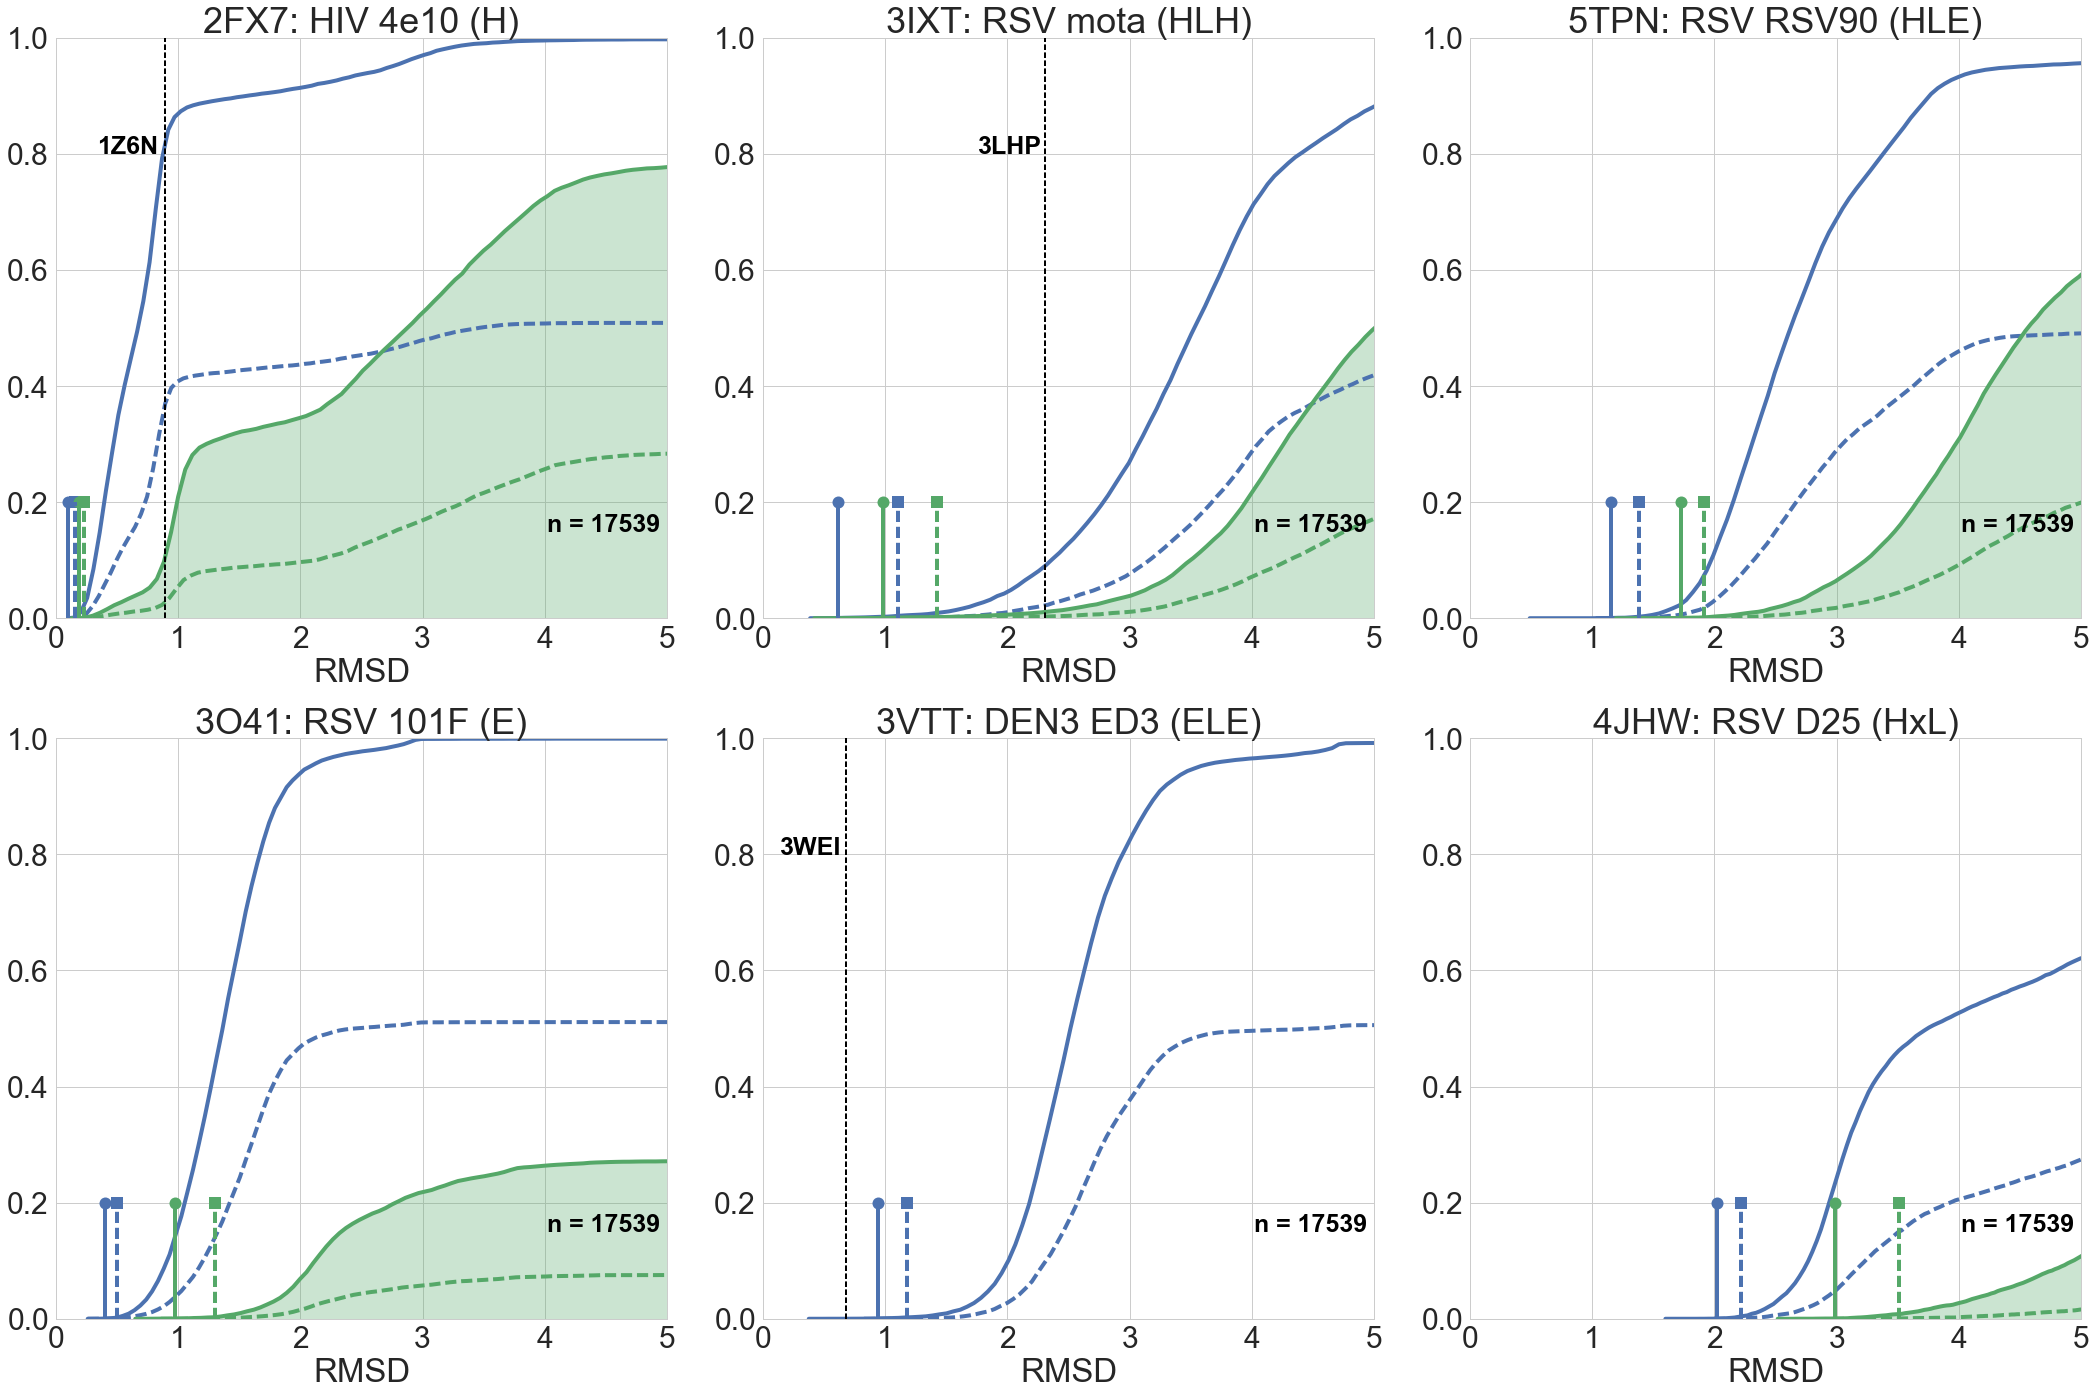

In [13]:
fig  = plt.figure(figsize=(30, 20))
grid = (2, 3)
ax11 = plt.subplot2grid(grid, (0, 0))
ax12 = plt.subplot2grid(grid, (0, 1))
ax13 = plt.subplot2grid(grid, (0, 2))
ax21 = plt.subplot2grid(grid, (1, 0))
ax22 = plt.subplot2grid(grid, (1, 1))
ax23 = plt.subplot2grid(grid, (1, 2))
if isinstance(dfs["2fx7"], pd.DataFrame):
    plot( dfs["2fx7"], "2fx7", total_master_list, "2FX7: HIV 4e10 (H)",    ax11, [0.89], ["1Z6N"], kcolor=["black"], annotate=True, top=top_limit, max_length=max_domain_size )
if isinstance(dfs["3ixt"], pd.DataFrame):
    plot( dfs["3ixt"], "3ixt", total_master_list, "3IXT: RSV mota (HLH)",  ax12, [2.31], ["3LHP"], kcolor=["black"], annotate=True, top=top_limit, max_length=max_domain_size )
if isinstance(dfs["5tpn"], pd.DataFrame):
    plot( dfs["5tpn"], "5tpn", total_master_list, "5TPN: RSV RSV90 (HLE)", ax13, annotate=True, top=top_limit, max_length=max_domain_size )
if isinstance(dfs["3o41"], pd.DataFrame):
    plot( dfs["3o41"], "3o41", total_master_list, "3O41: RSV 101F (E)",    ax21, annotate=True, top=top_limit, max_length=max_domain_size )
if isinstance(dfs["3vtt"], pd.DataFrame):
    plot( dfs["3vtt"], "3vtt", total_master_list, "3VTT: DEN3 ED3 (ELE)",  ax22, [0.68], ["3WEI"], kcolor=["black"], annotate=True, top=top_limit, max_length=max_domain_size )
if isinstance(dfs["4jhw"], pd.DataFrame):
    plot( dfs["4jhw"], "4jhw", total_master_list, "4JHW: RSV D25 (HxL)",   ax23, annotate=True, top=top_limit, max_length=max_domain_size )

plt.tight_layout()
plt.savefig("images/motif_recovery.svg")
plt.savefig("images/motif_recovery.png")
sns.plt.show()

(plotting with the new mota designs)

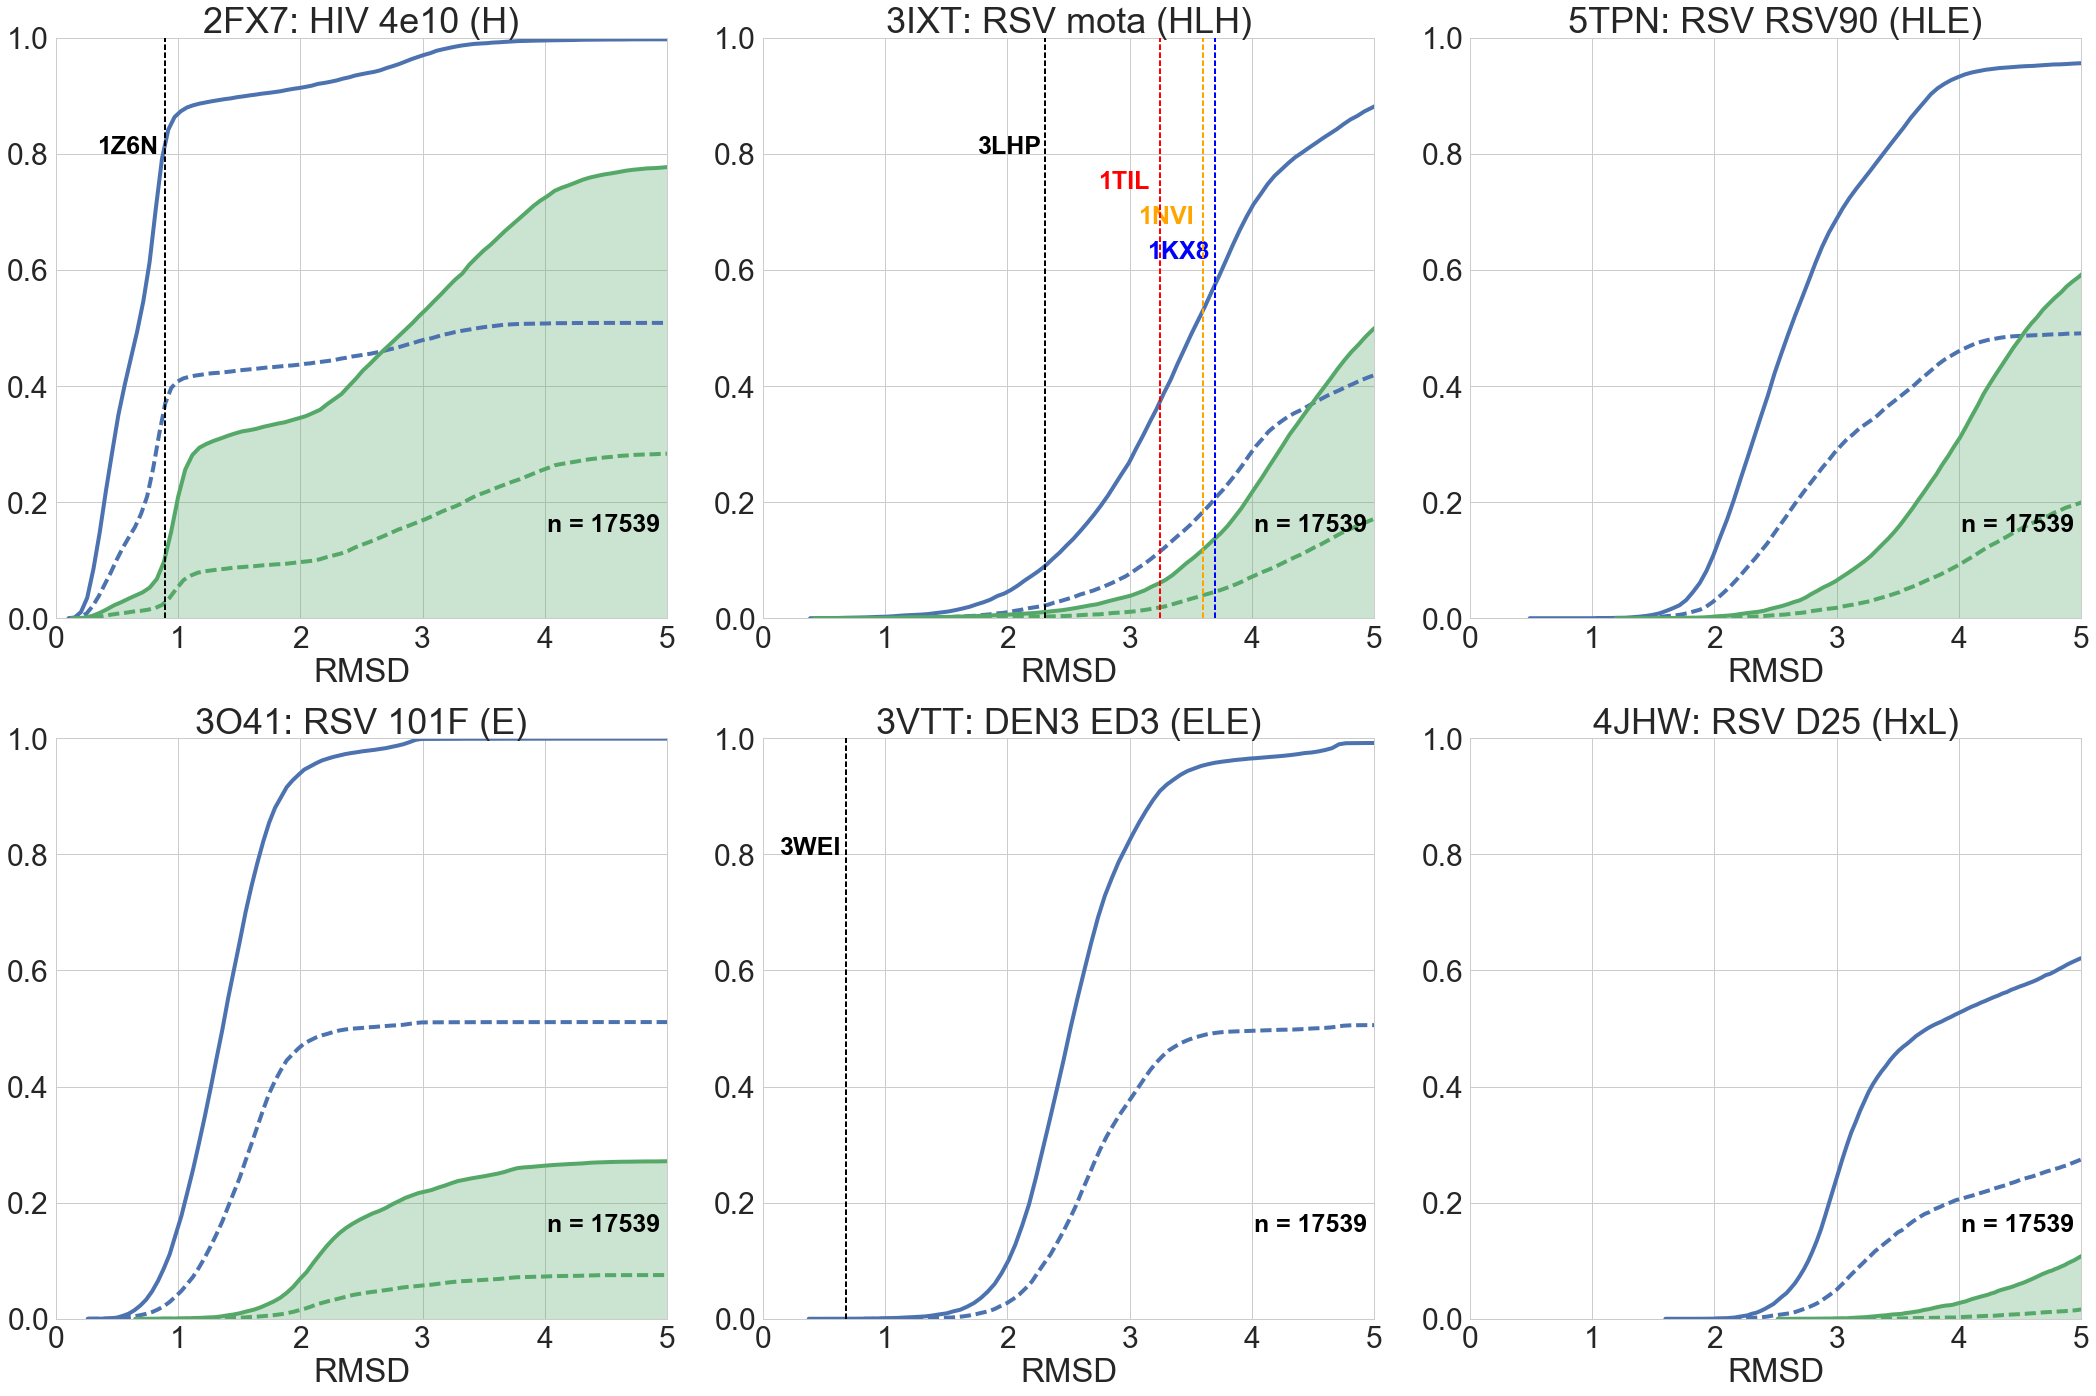

In [14]:
fig  = plt.figure(figsize=(30, 20))
grid = (2, 3)
ax11 = plt.subplot2grid(grid, (0, 0))
ax12 = plt.subplot2grid(grid, (0, 1))
ax13 = plt.subplot2grid(grid, (0, 2))
ax21 = plt.subplot2grid(grid, (1, 0))
ax22 = plt.subplot2grid(grid, (1, 1))
ax23 = plt.subplot2grid(grid, (1, 2))
plot( dfs["2fx7"], "2fx7", total_master_list, "2FX7: HIV 4e10 (H)",    ax11, [0.89], ["1Z6N"], kcolor=["black"], max_length=max_domain_size )
plot( dfs["3ixt"], "3ixt", total_master_list, "3IXT: RSV mota (HLH)",  ax12, [2.31, 3.25, 3.6, 3.7], ["3LHP", "1TIL", "1NVI", "1KX8"], kcolor=["black", "red", "orange", "blue"], max_length=max_domain_size )
plot( dfs["5tpn"], "5tpn", total_master_list, "5TPN: RSV RSV90 (HLE)", ax13, max_length=max_domain_size )
plot( dfs["3o41"], "3o41", total_master_list, "3O41: RSV 101F (E)",    ax21, max_length=max_domain_size )
plot( dfs["3vtt"], "3vtt", total_master_list, "3VTT: DEN3 ED3 (ELE)",  ax22, [0.68], ["3WEI"], kcolor=["black"], max_length=max_domain_size )
plot( dfs["4jhw"], "4jhw", total_master_list, "4JHW: RSV D25 (HxL)",   ax23, max_length=max_domain_size )
plt.tight_layout()
plt.savefig("images/motif_recovery_with_designs.svg")
plt.savefig("images/motif_recovery_with_designs.png")
sns.plt.show()